In [1]:
import requests
import os

from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.cm as cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import natural_earth
import shapefile
import numpy as np
from glob import glob
import xarray as xr

from datetime import datetime
import metpy
from metpy.units import units
import json as json
from matplotlib import patches as mpatches
import matplotlib.cm as cm

In [2]:
def load_ensemble(files):
    ptypes = ['rain', 'snow', 'icep', 'frzr']
    ds = xr.open_mfdataset(files, parallel=True)
    #variables = ['ML_rain', 'ML_snow', 'ML_frzr', 'ML_icep', 'ML_cicep', 'ML_cfrzr', 'ML_crain', 'ML_csnow', 'csnow', 'crain', 'cicep', 'cfrzr', 't_h']
    
    #ds = ds[variables]
    vars = []
    
    precip_sum = ds[['crain', 'csnow', 'cicep', 'cfrzr']].to_array().sum(dim='variable')
    for ptype in ptypes:
        ds[f'ML_{ptype}'] = xr.where(precip_sum >= 1, x=ds[f'ML_{ptype}'], y=0) 
        vars.append(f'ML_{ptype}')

    ptype_hier = ['frzr', 'icep', 'snow', 'rain']
    concat = xr.concat([ds[f'ML_{ptype}'] for ptype in ptype_hier], dim='ptype')
    concat_tle = concat.mean("time")
    max_idx = concat_tle.argmax(dim='ptype')

    concat_hrrr = xr.concat([ds[f'c{ptype}'] for ptype in ptype_hier], dim='ptype')
    concat_hrrr_tle = concat_hrrr.mean("time")
    max_idx_tle = concat_hrrr_tle.argmax(dim='ptype')

    for i, ptype in enumerate(ptype_hier):
        ds[f'ML_c{ptype}'] = xr.where(max_idx == i, 1, np.nan)  # set categorical values
        ds[ptype] = ds[f'ML_c{ptype}'] * ds[f'ML_{ptype}']  # set categorical scaled by probability
        ds[f'c{ptype}'] = xr.where((max_idx_tle == i) & (concat_hrrr_tle[i] != 0), concat_hrrr_tle[i], np.nan)
        vars.append(f'ML_c{ptype}')
        vars.append(f'c{ptype}')
        vars.append(ptype)

    #ds = ds[vars].mean("time").apply(lambda x: x.where(x != 0, np.nan))  # average and set 0 to nan in one line
    #ds = ds.mean("time")
    mask = precip_sum.mean("time") <= 0
    
    ds_changed = ds[vars].mean("time").where(~mask) # only mean the selected variables
    ds = ds.update(ds_changed)
    return ds

In [3]:
# Build kdTree
from pyproj import Proj, transform
from scipy.spatial import KDTree

class myKDTree():
    def __init__(self, longitudes, latitudes, proj):
        """
        Initialize the KDTreeHandler with latitude and longitude arrays.
        """
        self.latitudes = latitudes
        self.longitudes = longitudes
        self.proj = proj
        self.tree = None
        self.tree = self.build_tree()

    def build_tree(self):
        lcc_x, lcc_y = self.proj(self.longitudes, self.latitudes)
        lcc_points = np.vstack([lcc_x.ravel(), lcc_y.ravel()]).T
        tree = KDTree(lcc_points)
        return tree

    def query_tree(self, coord):
        # coord is (longitude, latitude)
        target_x, target_y = self.proj(coord[0], coord[1])
        distance, index = self.tree.query([target_x, target_y])
        y, x = divmod(index, latitudes.shape[1])
        return y, x

    def query(self, coords):
        '''
        Arguments:
            coords: list of coords in the form (longitude, latitude)
        '''
        coords = np.array(coords)
        target_x, target_y = self.proj(coords[:, 0], coords[:, 1])
        target_points = np.vstack([target_x, target_y]).T
        distances, indices = self.tree.query(target_points)
        y, x = np.divmod(indices, self.latitudes.shape[1])
        return y, x

In [4]:
def qc_mping(ds, json_data, snow_thresh=3, rain_thresh=-1, other_thresh=0, temp_crossings=(1, -2)):
    now = datetime.now()
    proj = Proj(proj='lcc', a=6371229, b=6371229, lon_0=262.5, lat_0=38.5, lat_1=38.5, lat_2=38.5)
    tree = myKDTree(ds.longitude, ds.latitude, proj)
    
    mping = []
    for res in json_data:
        coord = res['geom']['coordinates']

        # find the closest grid points to the lat, lon coordinate
        i, j = tree.query_tree(coord)

        ptype = res['description']
        # evaluate the grid point 
        
        # calculate surface wetbulb temp:
        T2m = ds['t2m'][:, i, j].metpy.convert_units('degC')  # Assuming the temperature is in Kelvin, convert to Celsius
        D2m = ds['d2m'][:, i, j].metpy.convert_units('degC')  # Assuming the dew point temperature is in Kelvin, convert to Celsius
        SP = ds['sp'][:, i, j].metpy.convert_units('hPa')  # Assuming the pressure is in Pa, convert to hPa

        # Ensure the data has units attached
        T2m = T2m.metpy.quantify()
        D2m = D2m.metpy.quantify()
        SP = SP.metpy.quantify()
                
        wbulb = metpy.calc.wet_bulb_temperature(SP, T2m, D2m).mean("time").values

        if ptype == 'Snow and/or Graupel':
            if np.any(wbulb < snow_thresh):
                mping.append(res)
        elif ptype == 'Rain':
            if np.any(wbulb > rain_thresh):
                mping.append(res)
        elif ptype == 'Freezing Rain' or ptype == 'Ice Pellets/Sleet':
            # check if temp crosses 0 celsius at least once.
            m = ds['t_h'][:, :, i, j].mean("time").values
            within_range = np.any(m > temp_crossings[0]) & np.any(m < temp_crossings[1])
            # at least one temp crossing and mping[filter] one temp crossing across all height levels
            if within_range and wbulb < other_thresh:
                mping.append(res)
    print(datetime.now() - now)
    return mping

In [5]:
file_list = ['/glade/derecho/scratch/sakor/20250526_test/hrrr/20210213/0000/MILES_ptype_hrrr_2021-02-13_0000_f18.nc',
            '/glade/derecho/scratch/sakor/20250526_test/hrrr/20210213/0100/MILES_ptype_hrrr_2021-02-13_0100_f18.nc',
            '/glade/derecho/scratch/sakor/20250526_test/hrrr/20210213/0200/MILES_ptype_hrrr_2021-02-13_0200_f18.nc',
            '/glade/derecho/scratch/sakor/20250526_test/hrrr/20210213/0500/MILES_ptype_hrrr_2021-02-13_0500_f18.nc',
            '/glade/derecho/scratch/sakor/20250526_test/hrrr/20210213/0400/MILES_ptype_hrrr_2021-02-13_0400_f18.nc']

In [6]:
ds = load_ensemble(file_list)

/glade/u/home/sakor/miniconda3/envs/ptype/lib/python3.10/site-packages/dask/utils.py:77: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  return func(*args, **kwargs)
/glade/u/home/sakor/miniconda3/envs/ptype/lib/python3.10/site-packages/dask/utils.py:77: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  return func(*args, **kwargs)
/glade/u/home/sakor/miniconda3/envs/ptype/lib/python3.10/site-packages/dask/utils.py:77: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  return func(*args, **kwargs)
/glade/u/home/sakor/miniconda3/envs/ptype/lib/

In [7]:
ds

<xarray.Dataset> Size: 9GB
Dimensions:            (time: 5, heightAboveGround: 21, y: 870, x: 1301,
                        isobaricInhPa: 40)
Coordinates:
  * heightAboveGround  (heightAboveGround) int64 168B 0 250 500 ... 4750 5000
  * time               (time) datetime64[ns] 40B 2021-02-13 ... 2021-02-13T05...
    step               timedelta64[ns] 8B 18:00:00
  * isobaricInhPa      (isobaricInhPa) float32 160B 1.013e+03 1e+03 ... 50.0
    latitude           (y, x) float32 5MB dask.array<chunksize=(870, 1301), meta=np.ndarray>
    longitude          (y, x) float32 5MB dask.array<chunksize=(870, 1301), meta=np.ndarray>
    valid_time         (time) datetime64[ns] 40B 2021-02-13T18:00:00 ... 2021...
    atmosphere         float32 4B 0.0
    meanSea            float32 4B 0.0
Dimensions without coordinates: y, x
Data variables: (12/45)
    t_h                (time, heightAboveGround, y, x) float32 475MB dask.array<chunksize=(1, 11, 435, 651), meta=np.ndarray>
    dpt_h              (time, heightAboveGround, y, x) float32 475MB dask.array<chunksize=(1, 11, 435, 651), meta=np.ndarray>
    u_h                (time, heightAboveGround, y, x) float32 475MB dask.array<chunksize=(1, 11, 435, 651), meta=np.ndarray>
    v_h                (time, heightAboveGround, y, x) float32 475MB dask.array<chunksize=(1, 11, 435, 651), meta=np.ndarray>
    isobaricInhPa_h    (time, heightAboveGround, y, x) float64 951MB dask.array<chunksize=(1, 7, 435, 651), meta=np.ndarray>
    t                  (time, isobaricInhPa, y, x) float32 905MB dask.array<chunksize=(1, 20, 435, 651), meta=np.ndarray>
    ...                 ...
    ML_frzr            (y, x) float32 5MB dask.array<chunksize=(870, 1301), meta=np.ndarray>
    ML_cfrzr           (y, x) float64 9MB dask.array<chunksize=(870, 1301), meta=np.ndarray>
    frzr               (y, x) float64 9MB dask.array<chunksize=(870, 1301), meta=np.ndarray>
    icep               (y, x) float64 9MB dask.array<chunksize=(870, 1301), meta=np.ndarray>
    snow               (y, x) float64 9MB dask.array<chunksize=(870, 1301), meta=np.ndarray>
    rain               (y, x) float64 9MB dask.array<chunksize=(870, 1301), meta=np.ndarray>

In [8]:
path_2_mping_json='/glade/campaign/cisl/aiml/ai2es/winter_ptypes/mping_hourly/mping_raw2021-02-13_18:00:00.json'

In [9]:
with open(path_2_mping_json) as f:
    json_data = json.load(f)

In [10]:
json_data[:5]

[{'id': 2638322,
  'obtime': '2021-02-13T18:00:37Z',
  'category': 'Rain/Snow',
  'description': 'Snow and/or Graupel',
  'description_id': 8,
  'geom': {'type': 'Point', 'coordinates': [-83.140159, 40.033364]}},
 {'id': 2638323,
  'obtime': '2021-02-13T18:00:46Z',
  'category': 'Rain/Snow',
  'description': 'Ice Pellets/Sleet',
  'description_id': 7,
  'geom': {'type': 'Point',
   'coordinates': [-75.04966226205558, 39.94867277817863]}},
 {'id': 2638324,
  'obtime': '2021-02-13T18:01:17Z',
  'category': 'Rain/Snow',
  'description': 'Freezing Rain',
  'description_id': 4,
  'geom': {'type': 'Point',
   'coordinates': [-83.05130675567906, 39.99469212479035]}},
 {'id': 2638325,
  'obtime': '2021-02-13T18:01:39Z',
  'category': 'Rain/Snow',
  'description': 'Snow and/or Graupel',
  'description_id': 8,
  'geom': {'type': 'Point', 'coordinates': [-122.3183656, 47.6836198]}},
 {'id': 2638326,
  'obtime': '2021-02-13T18:02:12Z',
  'category': 'Rain/Snow',
  'description': 'Mixed Freezing Ra

In [11]:
lcc_proj = Proj(proj='lcc', a=6371229, b=6371229, lon_0=262.5, lat_0=38.5, lat_1=38.5, lat_2=38.5)
latitudes = ds['latitude'].values
longitudes = ds['longitude'].values

tree = myKDTree(longitudes, latitudes, lcc_proj)

In [12]:
qc_data = qc_mping(ds, json_data)

0:01:33.550366


In [13]:
len(qc_data), len(json_data)

(105, 165)

In [14]:
import json
from collections import defaultdict
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from cartopy.io.shapereader import natural_earth
# import xesmf as xe
import cfgrib


import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def classify_precip(description):
    desc = description.lower()
    if "freezing drizzle" in desc or "freezing rain" in desc:
        return "Freezing Rain"
    elif "drizzle" in desc or "rain" in desc:
        return "Rain"
    elif "snow" in desc or "graupel" in desc:
        return "Snow"
    elif "sleet" in desc or "ice pellets" in desc:
        return "ice pellets"
    else:
        return "Other"

In [15]:
 
# Custom purple colormap
def mping_class(ax,json_data,extent):
    custom_colors = ['#f8f4f8', '#f005fc']
    purples = mcolors.LinearSegmentedColormap.from_list("custom", custom_colors)
    
    # Classification function
    def classify_precip(description):
        desc = description.lower()
        if "freezing drizzle" in desc or "freezing rain" in desc:
            return "Freezing Rain"
        elif "drizzle" in desc or "rain" in desc:
            return "Rain"
        elif "snow" in desc or "graupel" in desc:
            return "Snow"
        elif "sleet" in desc or "ice pellets" in desc:
            return "Ice Pellets"
        else:
            return "Other"
    
    # Grouping coordinates
    grouped_points = defaultdict(list)
    for obs in json_data:
        label = classify_precip(obs["description"])
        lon, lat = obs["geom"]["coordinates"]
        grouped_points[label].append((lon, lat))
    
    # Assign colormaps to classes
    colormap_dict = {
        "Rain": plt.colormaps["Greens"],
        "Snow": plt.colormaps["Blues"],
        "Freezing Rain": plt.colormaps["Reds"],
        "Ice Pellets": lambda x: '#f005fc'
    }
    
    # Plotting
   
    
    # extent = [-120, -75, 26, 50]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    
    # Plot each group with a distinct color from its colormap
    for i, (label, coords) in enumerate(grouped_points.items()):
        lons, lats = zip(*coords)
        cmap = colormap_dict.get(label, plt.cm.gray)
        color = cmap(0.7) if callable(cmap) else cmap # pick mid-shade
        ax.scatter(
            lons, lats,
            color=color,
            label=label,
            s=30,
            transform=ccrs.PlateCarree(),
            edgecolor='k', linewidth=0.3,
        )
    
    ax.legend(title="Precip Class", loc="lower left", fontsize="small")
    plt.title("Precipitation Types with Custom Colormaps")
    plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.08)
    plt.show()


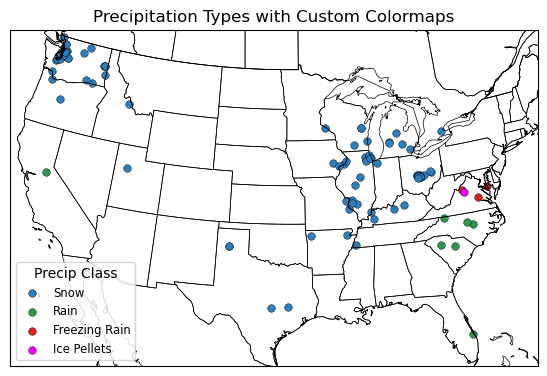

In [16]:
fig, ax = plt.subplots(
        figsize=(6, 4),
        subplot_kw={'projection': ccrs.LambertConformal()}
    )

mping_class(ax,qc_data, [-120, -75, 26, 50])

In [17]:
# import matplotlib.pyplot as plt
# import numpy as np

# gradient = np.linspace(0, 1, 256).reshape(1, -1)
# plt.imshow(gradient, aspect='auto', cmap=plt.colormaps['pink'])
# plt.title("matplotlib 'pink' colormap")
# plt.axis('off')
# plt.show()


In [18]:
def mask_cptye_with_gfs(path_2_credit, path_2_gfs):
    '''
    
    Function to mask credit ptype predictions  with gfs
    
    '''

    # load credit
    credit = xr.open_dataset(path_2_credit)
    
    gfs = xr.open_dataset(
        path_2_gfs,
        engine='cfgrib',
        backend_kwargs={'filter_by_keys': {'stepType': 'instant', 'typeOfLevel': 'surface'}},
        decode_timedelta=False, 
    )
    # create a no_precip class for gfs 
    gfs['no_precip'] = (
            (gfs['crain'] == 0) & 
            (gfs['csnow'] == 0) & 
            (gfs['cfrzr'] == 0) & 
            (gfs['cicep'] == 0)
        )
    # interpolate to match credit grid
    no_precip_numeric = gfs['no_precip'].astype(int)
    gfs_regridded = no_precip_numeric.interp(
        latitude=credit.isel(time=0).variables['latitude'].copy(), 
        longitude=credit.isel(time=0).variables['longitude'].copy(), 
        method='nearest'
    )
    gfs_regridded = gfs_regridded.astype(bool)

 
    credit_masked = credit.where(~gfs_regridded)
    return credit_masked

In [19]:
def conus_plot(ax, data, extent, title, show_legend = False, if_gfs = False):
    # Set up map projection and features
    crs = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
     
    ptypes = ['crain', 'csnow', 'cfrzr', 'cicep']
    
    if not if_gfs:
        data = data.isel(time = 0)
        ptypes = ['ML_crain', 'ML_csnow', 'ML_cfrzr', 'ML_cicep']

    data = data.assign_coords(longitude=((data.longitude + 180) % 360) - 180)
    
    # Load and prepare CONUS mask
    conus_mask = xr.open_dataset('/glade/work/sakor/ptype-physical/scripts/conus_mask.nc')['conus_mask']
    conus_mask =conus_mask.sortby('longitude')
    
    custom_colors = ['#f8f4f8', '#f005fc']
    purples = mcolors.LinearSegmentedColormap.from_list("custom", custom_colors)
    cmaps = ['Greens', 'Blues', 'Reds', purples]

       
    data = data.sortby('longitude')

    # Convert boolean mask to float (1.0=True, 0.0=False) before interpolation
    conus_mask = conus_mask.astype(float).interp(
        longitude=data.longitude,
        latitude=data.latitude,
        method='nearest'
    )
    
    # Convert back to boolean after interpolation 
    conus_mask = conus_mask > 0.5
    
    for ptype in ptypes:
        data[ptype] = data[ptype].where(conus_mask, other=np.nan) 
        
    lat,lon = data['latitude'].values, data['longitude'].values
    for i, ptype in enumerate(ptypes):
        masked_data = np.where(data[f'{ptype}'] > 0.5, data[f'{ptype}'], np.nan)
        h = ax.pcolormesh(
            lon, lat,
            masked_data,
            transform=ccrs.PlateCarree(),
            cmap=cmaps[i],
            vmin=0,
            vmax=1,
              
        )
    ax.set_title(title, fontweight='regular', fontsize=11, loc='left')
    ptypes = ['crain', 'csnow', 'cfrzr', 'cicep']
    legend_handles = [
    mpatches.Patch(color=plt.get_cmap(cmaps[i])(0.6), label=ptype) 
        for i, ptype in enumerate(ptypes)
    ]
    if show_legend:
        ax.legend(
            handles=legend_handles,
            bbox_to_anchor = (1.05,0.5),
            loc='lower left',
            title='Precipitation Types',
            fontsize=8,
            title_fontsize=10
            )
    return 

In [20]:
 
# Custom purple colormap
def mping_class(ax,json_data,extent, legend = False):
    custom_colors = ['#f8f4f8', '#f005fc']
    purples = mcolors.LinearSegmentedColormap.from_list("custom", custom_colors)
    
    # Classification function
    def classify_precip(description):
        desc = description.lower()
        if "freezing drizzle" in desc or "freezing rain" in desc:
            return "Freezing Rain"
        elif "drizzle" in desc or "rain" in desc:
            return "Rain"
        elif "snow" in desc or "graupel" in desc:
            return "Snow"
        elif "sleet" in desc or "ice pellets" in desc:
            return "Ice Pellets"
        else:
            return "Other"
    
    # Grouping coordinates
    grouped_points = defaultdict(list)
    for obs in json_data:
        label = classify_precip(obs["description"])
        lon, lat = obs["geom"]["coordinates"]
        grouped_points[label].append((lon, lat))
    
    # Assign colormaps to classes
    colormap_dict = {
        "Rain": plt.colormaps["Greens"],
        "Snow": plt.colormaps["Blues"],
        "Freezing Rain": plt.colormaps["Reds"],
        "Ice Pellets": lambda x: '#f005fc'
    }
    
    # Plotting
   
    
    # extent = [-120, -75, 26, 50]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    
    # Plot each group with a distinct color from its colormap
    for i, (label, coords) in enumerate(grouped_points.items()):
        lons, lats = zip(*coords)
        cmap = colormap_dict.get(label, plt.cm.gray)
        color = cmap(0.7) if callable(cmap) else cmap  # pick mid-shade
        ax.scatter(
            lons, lats,
            color=color,
            label=label,
            s=30,
            transform=ccrs.PlateCarree(),
            edgecolor='k', linewidth=0.3,
        )
    if legend:
        ax.legend(title="Precip Class", loc="lower left", fontsize="small")
        
    # plt.title("Precipitation Types with Custom Colormaps")
    # plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.08)
    # plt.show()


In [22]:
path1 = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-02-13T00Z/pred_2021-02-13T00Z_018.nc'
path2 = '/glade/u/home/sakor/work/CREDIT/fuxi_6h/2021-02-13T00Z/pred_2021-02-13T00Z_018.nc'
path3 = '/glade/u/home/sakor/work/CREDIT/wx_former_1h/2021-02-13T00Z/pred_2021-02-13T00Z_018.nc'
path4 = '/glade/work/sakor/gfs/gfs.0p25.2021021318.f000.grib2'

In [23]:
gfs = xr.open_dataset(
        path4,
        engine='cfgrib',
        backend_kwargs={'filter_by_keys': {'stepType': 'instant', 'typeOfLevel': 'surface'}},
        decode_timedelta=False, 
    )

In [24]:
wx_6h = mask_cptye_with_gfs(path1,path4)
wx_1h =mask_cptye_with_gfs(path3,path4)
fuxi_6h =  mask_cptye_with_gfs(path2,path4)

/glade/derecho/scratch/sakor/tmp/ipykernel_120998/1664195255.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


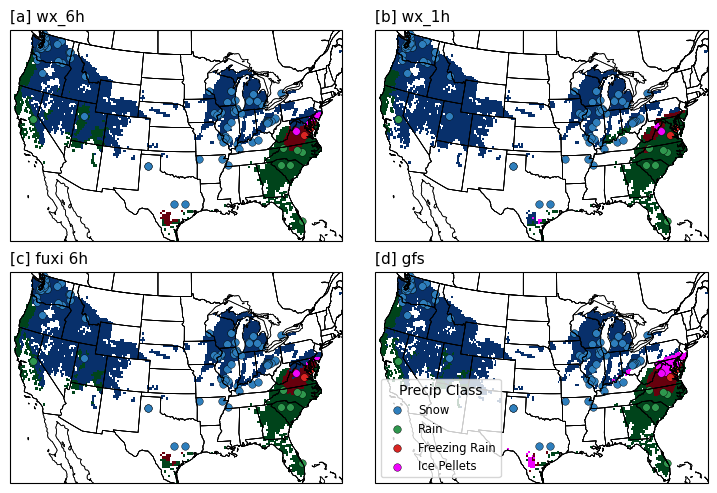

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 6),
                       gridspec_kw={'wspace': 0.1, 'hspace': 0.1},
                       subplot_kw={'projection': ccrs.LambertConformal()})
extent = [-120, -75, 26, 50]


conus_plot(ax[0,0],wx_6h,extent, '[a] wx_6h')  
mping_class(ax[0,0],qc_data, [-120, -75, 26, 50])

conus_plot(ax[0,1],wx_1h,extent, '[b] wx_1h') 
mping_class(ax[0,1],qc_data, [-120, -75, 26, 50])

conus_plot(ax[1,0],fuxi_6h,extent, '[c] fuxi 6h') 
mping_class(ax[1,0],qc_data, [-120, -75, 26, 50])

conus_plot(ax[1,1],gfs,extent, '[d] gfs', show_legend = False, if_gfs= True) 
mping_class(ax[1,1],qc_data, [-120, -75, 26, 50], legend = True)
plt.tight_layout()